# Character-Level Bigram Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

This is based on [this tutorial](https://www.youtube.com/watch?v=PaCmpygFfXo) on language modeling. We will use a dataset of names to train a bigram character-level language model for generating new names. This will in further notebooks complexify into a modern [Transformer](https://arxiv.org/abs/1706.03762) language model (such as [GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)). 

In this notebook, the focus is on introducing the overall framework of language modeling that includes probabilistic modeling, model training, sampling, and the evaluation of a loss (e.g. the negative log likelihood for classification). Probabilities of bigrams will be modeled by (1) counting and (2) using a simple neural network with a single hidden layer.

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

## Names dataset

First, we get the dataset of names that we will model:

In [2]:
import urllib

URL = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
urllib.request.urlretrieve(URL, DATASET_DIR / 'names.txt');

words = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
print(len(words))
words[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

A name is simply a sequence of characters. Language modeling is assigning probabilities to a sequence of characters. Our dataset which consists of over 32,000 names has a lot of structure both local (character-level) and global (name-level). 

Note that our names are not infinite sequences &mdash; it has a start and an end. So we have to have tokens for these delimiters. Moreover, most names have zero probability of occuring, i.e. names with the end token before the start token. We will develop a weak model which essentially models [Markov process](https://en.wikipedia.org/wiki/Markov_chain) of length 1. To model this, we have use **bigrams**. Bigrams of the first name are: 

In [3]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        print(c1, c2)

<S> e
e m
m m
m a
a <E>


Getting all bigrams:

In [4]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

The following bigrams occur most frequently. For instance, `a` occurs as the first letter in 4410 names. And most names end with `n` and `a`. 

In [5]:
sorted(b.items(), key=lambda kv: -kv[1])[:20]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422)]

## Counting bigrams

To structure the data better, we will store this in a 2D array. An entry `[i, j]` in this array is the count of bigrams that start with the `i`th character followed by the `j`th character. Also, we incorporate the following fact that a single delimiter suffices. That is, we can use a `.` to signify the start of a name which will be closed by another `.` to signify the end of a name. 

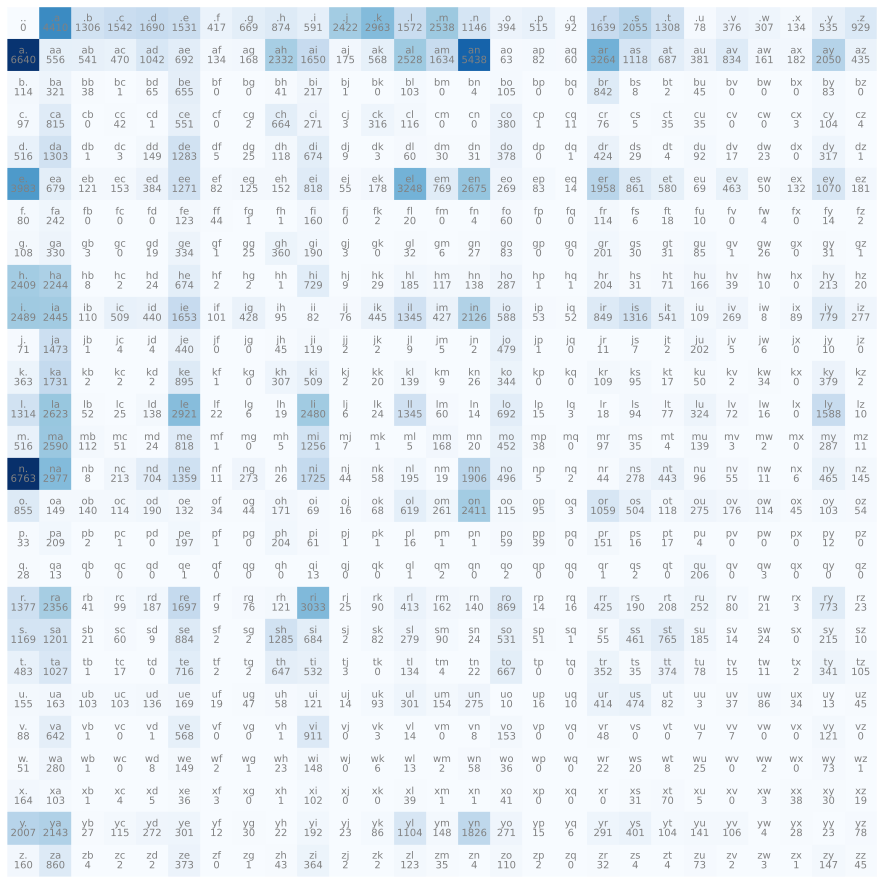

In [6]:
import torch

# Create count matrix
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(chars)}
n = len(chars)
N = torch.zeros((n, n), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        N[stoi[c1], stoi[c2]] += 1

# Visualize count matrix
itos = {i: s for s, i in stoi.items()}
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')

plt.axis('off');

### Generating names

Already at this point we can generate names. Recall that to model joint distributions, we can use a [chain of probabilities](https://d2l.ai/chapter_recurrent-neural-networks/sequence.html#markov-models). But conditioning only on the last character as a form of truncation. Given a discrete joint probability `P`, we sample the first character of a name from a marginal distribution and go from there sampling each character conditioned purely on the previous sampled character. This conditional distribution corresponds to `P[ix, :] / P[ix, :].sum()` where `ix` is the index of the previous character. 

In [7]:
def generate_names(P, n, seed=2147483647):
    """Generate names from a Markov process with joint probability P."""

    g = torch.Generator().manual_seed(seed)
    P /= P.sum(dim=1, keepdim=True)
    names = []
    for _ in range(n):
        ix = 0
        out = []
        while True:
            p = P[ix]
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            out.append(itos[ix])
            if ix == 0:
                break    
        names.append(''.join(out[:-1]))
    return names

Generate names from the joint distribution estimated by counting:

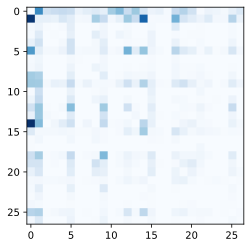

In [8]:
P = N.float() / N.sum()
plt.imshow(P, cmap='Blues');

In [9]:
generate_names(P, 10)

['mor',
 'axx',
 'minaymoryles',
 'kondlaisah',
 'anchshizarie',
 'odaren',
 'iaddash',
 'h',
 'jhinatien',
 'egushl']

Note that modeling using bigrams is pretty bad. But it still looks better than random. One reason this is bad is that the next most probable bigram has probability that drops exponentially from the last. This is known as [Zipf's law](https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html#exploratory-language-statistics). Interestingly, this holds even for trigrams, and so on, and even for word-level language modeling.

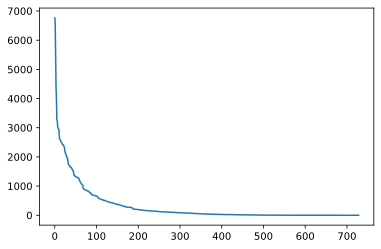

In [10]:
plt.plot(sorted(N.reshape(-1), reverse=True));

### Model quality

The **likelihood** of a dataset is the probability assigned by the model on that dataset. This can be expressed as a product of likelihood of data points. Since a product of many small positive numbers quickly vanishes to zero, we typically take the logarithm which converts this product into a sum. Hence, we take the **log-likelihood** for describing a model.

[Maximum likelihood estimation](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle) (MLE) means choosing the model parameters (e.g. assignment of probabilities) such that the likelihood of the dataset is maximized. Since we typically want to minimize a positive function, MLE is equivalent to minimizing the **negative log-likelihood** (NLL). Hence, we take the NLL as the loss function for the model. Note that we take the mean to normalize the loss value over the size of the dataset.

In [11]:
class BigramModel:
    def __init__(self, P):
        """
        Sequence model that uses bigrams / Markov process 
        for estimating probability of next char: P(b | a).
        """
        self.P = P
        self.P /= self.P.sum(dim=1, keepdim=True)

    def __call__(self, a, b) -> float:
        p = self.P[stoi[a], stoi[b]]
        return p

bigram_model = BigramModel(P)

Compute NLL of bigram model:

In [12]:
# Creating input-target sequences
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])


# Computing NLL
log_likelihood = 0.0
n = 0
for x, y in zip(xs, ys):
    c1 = itos[x]
    c2 = itos[y]
    p = bigram_model(c1, c2)
    log_p = torch.log(p)
    log_likelihood += log_p
    n += 1
    if n < 12:
        print(f'{c2}   {c1}{c2}   p={p:.4f}   nll={-log_p:.4f}')

nll = -log_likelihood
print(f"nll = {nll / n:.4f} (overall)")

e   .e   p=0.0478   nll=3.0408
m   em   p=0.0377   nll=3.2793
m   mm   p=0.0253   nll=3.6772
a   ma   p=0.3899   nll=0.9418
.   a.   p=0.1960   nll=1.6299
o   .o   p=0.0123   nll=4.3982
l   ol   p=0.0780   nll=2.5508
i   li   p=0.1777   nll=1.7278
v   iv   p=0.0152   nll=4.1867
i   vi   p=0.3541   nll=1.0383
a   ia   p=0.1381   nll=1.9796
nll = 2.4541 (overall)


Observe that a model that assigns a probability of `1.0` for each next actual character has an NLL of exactly `0.0`. Here our bigram model gets penalized for next characters whose bigrams from the previous character occurs rarely on the training dataset.

### Smoothing

Note that the penalty can even result in `+inf` loss when this encounters a bigram with zero counts in the training data, e.g. the name `gopde` since the bigram `pd` never appears on the training data. One way to fix this is to perform **model smoothing**. This can be done by adding a fixed constant to the counts:

```python
a = 2
P = (N + a).float() / (N + a).sum()
```

The larger the constant `a`, the more uniform the resulting probabilities are. Hence, the term smoothing. 

## Modeling probabilities with a neural network

We will still model names using bigrams, but the assignment of conditonal probabilities is estimated by initializing random weights which is fine-tuned using gradient descent. Again we want to maximize the probabilities of the actual next characters so that the likelihood of the training dataset is maximized. Constructing our sequence data:

In [13]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

Since neural nets can only handle numbers, our input data are encoded as integers. But how do we plug this into a neural net? An easy way to do this is to use one-hot vectors. Note that we convert to float since we want to push these into a neural net with float weights. This can be done using `.float()` since `F.one_hot` does not take in a `dtype` argument. The alternative is to use a single unit as input neuron, but this doesn't seem like a good idea.

tensor([ 0,  5, 13, 13,  1])


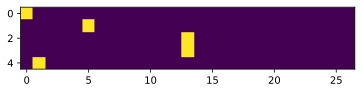

In [14]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
print(xs[:5])
plt.imshow(xenc[:5, :]); # 0, 5, 13, 13, 1, ...

The design of our neural net is to have a single hidden layer with weights `W` of size  `(27, 27)`. The entries of `W` correspond to the same joint probability distribution as above (or to the count matrix). In particular, each row of the matrix `W` correspond to a probability distribution of the next character. This conditional distribution is picked out via matrix multiplication with the one-hot encoding of the index.

In [15]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

(xenc @ W).shape

torch.Size([228146, 27])

Each entry of `W` is interpreted as **log-counts** (perhaps scaled). This is then exponentiated to get to units of count. Note that the probabilities are obtained by normalizing the counts. This corresponds to using `softmax` on the counts to get a probability.

In [16]:
class NNModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W                         # init -> log-counts
        counts = logits.exp()                          # nonlinearity -> counts
        probs = counts / counts.sum(1, keepdims=True)  # softmax -> probability
        return probs
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad

### Model training

In [17]:
model = NNModel(seed=12)

losses = []
num_steps = 100
for k in range(num_steps):
    probs = model(xs)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()  # nll
    if k % 10 == 9:
        print(f"[{k+1:>03d}/{num_steps}] nll={loss:.4f}")

    # gradient descent    
    model.zero_grad()
    loss.backward()
    model.optim_step(lr=50.0)

    losses.append(loss.item())

[010/100] nll=2.6704
[020/100] nll=2.5613
[030/100] nll=2.5241
[040/100] nll=2.5052
[050/100] nll=2.4939
[060/100] nll=2.4865
[070/100] nll=2.4814
[080/100] nll=2.4776
[090/100] nll=2.4747
[100/100] nll=2.4724


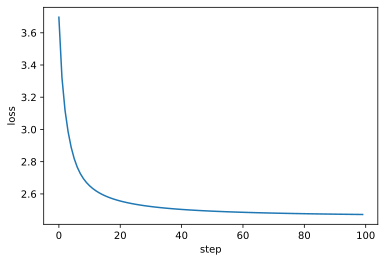

In [18]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

For more complex neural nets, the only thing that will change is how to compute and assign probabilities to the next character. For example, we can use trigrams. Although, this is already looking like a not scalable approach. Another thing we can try is to have more complex neural network architecture for computing character dependencies.

### Sampling

In [19]:
counts = model.W.exp()
probs = counts / counts.sum() 
[print(n) for n in generate_names(probs, n=10)];

mor
axwaninaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jionatien
egxver
ga


It looks like we recovered the original count matrix (or similar)!

### Regularization

Observe that smoothing the count matrix approximates to it having constant entries. In the context of the neural net model, this means having a zero weight matrix so that the "count" matrix is equal to the exponential of the weights `W.exp()`.  

The more getting zero weights is incentivized in the loss function, the more uniform the resulting distribution is. This is precisely **regularization**. For example, we can add $\lVert \boldsymbol{\mathsf W} \rVert^2_2$ in the loss function. This acts sort of like a gravitational force that pushes the weights to zero whenever it increases to try to reduce the NLL loss.

```python
loss += 10.0 * model.W.square().mean()
```

## Appendix: Exercises

* E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

* E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

* E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

* E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

* E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

* E06: meta-exercise! Think of a fun/interesting exercise and complete it.
